# Import libraries and read the DataFrame

In [1]:
#!pip install imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Load dataset
data = pd.read_csv('./data/emdat_1900-2024_cleaned.csv')

data.columns
# len(np.unique(data['Disaster Type']))
# print(np.unique(data['Disaster Group']))

# Select top 5 features based on chi2 score
selector = SelectKBest(score_func=chi2, k=8)  # Select the top 5 features
X_new = selector.fit_transform(features, target)

# Get the feature scores and corresponding feature names
scores = selector.scores_
feature_names = features.columns

# Create a DataFrame to display feature names and their corresponding scores
feature_scores = pd.DataFrame({'Feature': feature_names, 'Score': scores})

# Sort by score in descending order
feature_scores_sorted = feature_scores.sort_values(by='Score', ascending=False)

# Display the top features
print(feature_scores_sorted.head(8))

NameError: name 'features' is not defined

In [20]:
# One-hot encoding the Magnitude Scale column
magnitude_dummies = pd.get_dummies(data['Magnitude Scale'], prefix='Magnitude')

# Concatenate the one-hot encoded columns with the original dataframe
data = pd.concat([data, magnitude_dummies], axis=1)

# Extract relevant features and target feature
features = data[['Disaster Type', 'Total Deaths', 'Total Affected', 'No. Injured', 'No. Affected', 'CPI', 'Start Month', 'End Month'] 
                + list(magnitude_dummies.columns)]
#features = data[['Total Deaths', 'Total Affected', 'No. Injured', 'No. Affected']]
target = data['Subregion']

# Encode categorical variables
label_encoder = LabelEncoder()
features['Disaster Type'] = label_encoder.fit_transform(features['Disaster Type'])

# Drop duplicate columns if they exist
data = data.loc[:, ~data.columns.duplicated()]
data
# Check for unique values in the 'Magnitude Scale' column

print(features)
# # Select top 5 features based on chi2 score
# selector = SelectKBest(score_func=chi2, k=8)  # Select the top 5 features
# X_new = selector.fit_transform(features, target)

# # Get the feature scores and corresponding feature names
# scores = selector.scores_
# feature_names = features.columns

# # Create a DataFrame to display feature names and their corresponding scores
# feature_scores = pd.DataFrame({'Feature': feature_names, 'Score': scores})

# # Sort by score in descending order
# feature_scores_sorted = feature_scores.sort_values(by='Score', ascending=False)

# # Display the top features
# print(feature_scores_sorted.head(8))
print(data['Region'].unique())

       Disaster Type  Total Deaths  Total Affected  No. Injured  No. Affected  \
0                 28   6000.000000    4.938414e+05  1283.685936  7.783234e+05   
1                 11    300.000000    4.938414e+05  1283.685936  7.783234e+05   
2                 13    300.000000    4.938414e+05  1283.685936  7.783234e+05   
3                  7     30.000000    4.938414e+05  1283.685936  7.783234e+05   
4                 29     30.000000    4.938414e+05  1283.685936  7.783234e+05   
...              ...           ...             ...          ...           ...   
26788              5   1553.451113    7.600000e+06  1283.685936  7.600000e+06   
26789              5   1553.451113    2.660000e+05  1283.685936  2.660000e+05   
26790              5   1553.451113    1.655000e+06  1283.685936  1.655000e+06   
26791              5   1553.451113    1.000000e+05  1283.685936  1.000000e+05   
26792              5   1553.451113    2.800000e+06  1283.685936  2.800000e+06   

             CPI  Start Mon

C:\Users\Stefa\AppData\Local\Temp\ipykernel_15280\2339457811.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Disaster Type'] = label_encoder.fit_transform(features['Disaster Type'])


Fit a simple SVM model

In [4]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC()

svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm.predict(X_test_scaled)

# Evalute accuracy 
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.2756111214778877


Apply SMOTE Technique

In [5]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

svm = SVC()

svm.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = svm.predict(X_test_scaled)

# Evalute accuracy 
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.13509983205821982


Perform Hyperparameter tuning - RandomizedSearchCV

In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Apply SMOTE to handle class imbalance
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use a smaller portion of the training set for hyperparameter tuning
X_train_small, _, y_train_small, _ = train_test_split(X_train_scaled, y_train, test_size=0.7, random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 5],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced']
}

# Initialize the SVM model
svm = SVC()

# Apply RandomizedSearchCV for hyperparameter tuning on the small dataset
random_search = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train_small, y_train_small)

# Best parameters found by RandomizedSearchCV
print(f"Best parameters: {random_search.best_params_}")

Best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'C': 1}


In [10]:
# Best parameters found by RandomizedSearchCV
best_params = random_search.best_params_

# Initialize a new SVM model with the best parameters
svm_best = SVC(C=best_params['C'], 
               gamma=best_params['gamma'], 
               kernel=best_params['kernel'], 
               class_weight=best_params['class_weight'])

# Train the model on the full training set
svm_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm_best.predict(X_test_scaled)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# Evaluate the model
print(classification_report(y_test, y_pred))

Accuracy: 0.28
                                 precision    recall  f1-score   support

      Australia and New Zealand       0.00      0.00      0.00        75
                   Central Asia       0.00      0.00      0.00        48
                   Eastern Asia       0.33      0.42      0.37       632
                 Eastern Europe       0.24      0.04      0.06       225
Latin America and the Caribbean       0.25      0.20      0.22       835
                      Melanesia       0.00      0.00      0.00        49
                     Micronesia       0.00      0.00      0.00        13
                Northern Africa       0.00      0.00      0.00       175
               Northern America       0.27      0.25      0.26       361
                Northern Europe       0.00      0.00      0.00        82
                      Polynesia       0.00      0.00      0.00        18
             South-eastern Asia       0.33      0.01      0.02       565
                  Southern Asia    

C:\Users\Stefa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stefa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stefa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Convert cv_results_ to a DataFrame for easier plotting
results = pd.DataFrame(grid_search.cv_results_)

# Convert 'param_C' and 'param_gamma' to strings to avoid the TypeError
results['param_C'] = results['param_C'].astype(str)
results['param_gamma'] = results['param_gamma'].astype(str)
                                                       
# Plotting the effect of 'C' and 'gamma' on the model's mean test score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='param_C', y='param_gamma', size='mean_test_score', hue='mean_test_score', data=results, palette='viridis', sizes=(20, 200))
plt.title('Grid Search Results (Mean Test Score by C and Gamma)')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.colorbar(label='Mean Test Score')
plt.show()

Perform Hyperparameter tuning - GridSearchCV

In [11]:
# Apply GridSearchCV for hyperparameter tuning on the small dataset
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_small, y_train_small)

# Best parameters found by GridSearchCV
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'C': 5, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}


In [13]:
# Train the model using the best parameters
best_model_random = random_search.best_estimator_

# Make predictions with the best model
y_pred_random = best_model_random.predict(X_test_scaled)

# Evaluate accuracy and classification report
accuracy_random = accuracy_score(y_test, y_pred_random)
class_report_random = classification_report(y_test, y_pred_random)

print(f"Accuracy (Grid Search): {accuracy_random}")
print(f"Classification Report (Grid Search):\n{class_report_random}")


Accuracy (Grid Search): 0.26684082851278224
Classification Report (Grid Search):
                                 precision    recall  f1-score   support

      Australia and New Zealand       0.00      0.00      0.00        75
                   Central Asia       0.00      0.00      0.00        48
                   Eastern Asia       0.30      0.32      0.31       632
                 Eastern Europe       0.16      0.02      0.04       225
Latin America and the Caribbean       0.24      0.24      0.24       835
                      Melanesia       0.00      0.00      0.00        49
                     Micronesia       0.00      0.00      0.00        13
                Northern Africa       0.00      0.00      0.00       175
               Northern America       0.25      0.23      0.24       361
                Northern Europe       0.00      0.00      0.00        82
                      Polynesia       0.00      0.00      0.00        18
             South-eastern Asia       0.00

C:\Users\Stefa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stefa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stefa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix 

<Figure size 1440x1152 with 0 Axes>

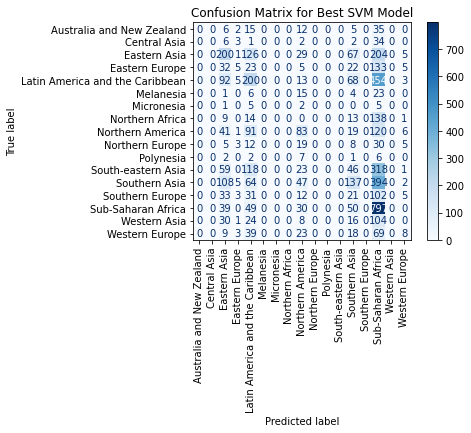

In [18]:
# Compute the Confusion Matrix
conf_matr = confusion_matrix(y_test, y_pred_random)

# Create the confusion matrix display
plt.figure(figsize=(20, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=best_model_random.classes_)
disp.plot(cmap=plt.cm.Blues)

# Set labels and title
plt.title('Confusion Matrix for Best SVM Model')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Define the parameter grid for LinearSVC
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l2'],  # The 'l2' penalty is the default for LinearSVC
    'max_iter': [1000, 2000, 5000],  # Maximum number of iterations
    'class_weight': [None, 'balanced']  # Handle class imbalance
}

# Create a LinearSVC model instance
linear_svc = LinearSVC()

# Initialize RandomizedSearchCV (with n_iter to limit the number of combinations)
random_search = RandomizedSearchCV(estimator=linear_svc, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Fit random search to the data
random_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

# Train the model using the best parameters
best_model_random = random_search.best_estimator_

# Make predictions with the best model
y_pred_random = best_model_random.predict(X_test_scaled)

# Evaluate accuracy and classification report
accuracy_random = accuracy_score(y_test, y_pred_random)
class_report_random = classification_report(y_test, y_pred_random)

print(f"Accuracy (Randomized Search): {accuracy_random}")
print(f"Classification Report (Randomized Search):\n{class_report_random}")



In [ ]:
# Split data into training and test 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Initialize and train the SVM
svm_model = LinearSVC()#penalty='l2', C=1, max_iter=1000)#penalty='l2', class_weight='balanced', max_iter=1000)#kernel='linear', C=10, gamma='scale', class_weight='balanced')
svm_model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = svm_model.predict(X_test_scaled)

# Evalute accuracy 
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

# Display the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

In [ ]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Initialize and train the SVM
svm_model = SVC()
svm_model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = svm_model.predict(X_test_scaled)

# Evaluate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
#print(classification_report(y_test, y_pred))

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Train the SVM model on the 2D PCA-transformed data
svm_model.fit(X_pca, y_train)
# Create a mesh to plot the decision boundary
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict over the grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

# Plot the training points
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=30, edgecolors='k', cmap=plt.cm.coolwarm)

# Set labels and titles
plt.xlabel('Total Deaths (scaled)')
plt.ylabel('Total Affected (scaled)')
plt.title('SVM Decision Surface')

# Show the plot
plt.show()


In [15]:
# Compute the Confusion Matrix
conf_matr = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20,16))
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)

# Set labels and title
plt.title('Confusion Matrix for SVM')
plt.xticks(rotation=90)
plt.show()

AttributeError: 'SVC' object has no attribute 'classes_'

<Figure size 1440x1152 with 0 Axes>

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")


# SVM

Implementing feature selection, data encoding, K-fold cross validation, and fitting SVM model

In [ ]:
# Select features and target
features = ['Country', 'Total Deaths', 'No. Affected', 'No. Injured', 'Disaster Group', 'Disaster Subgroup']
target = 'Disaster Type'

# Encode categorical features
data_encoded = pd.get_dummies(data[features])

# Scale numeric features
scaler = StandardScaler()
data_encoded_scaled = scaler.fit_transform(data_encoded)

# Encode the target (Disaster Type)
le = LabelEncoder()
data['Disaster Group Encoded'] = le.fit_transform(data[target])

# Split data into features (X) and target (y)
X = data_encoded_scaled
y = data['Disaster Group Encoded']

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data_encoded_scaled, data['Disaster Group Encoded'], test_size=0.3, random_state=42)

# Implement K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train SVM model
svm_model = SVC()

# Cross-validation scores
cv_scores = cross_val_score(svm_model, X, y, cv=kf, scoring='accuracy')

# Print the cross-validation results
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean() * 100:.2f}%')

# 2. Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],        # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['linear', 'rbf']  # Kernel type
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=kf, scoring='accuracy')

# Fit grid search
grid_search.fit(X, y)

# Best hyperparameters found by GridSearchCV
print(f'Best hyperparameters: {grid_search.best_params_}')

# Best model after hyperparameter tuning
best_svm_model = grid_search.best_estimator_

# Train and evaluate the best model
best_svm_model.fit(X, y)

# Predict on the same data (for example)
y_pred = best_svm_model.predict(X)

# Evaluate accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy with best model: {accuracy * 100:.2f}%')
# svm_model.fit(X_train, y_train)

# # Predict on test set
# y_pred = svm_model.predict(X_test)

# # Evaluate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy * 100:.2f}%')


Display Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute the Confusion Matrix
conf_matr = confusion_matrix(y_test, y_pred)

# Plot the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM Model')
plt.show()